# Forecasting Model with XGBOOST

This is the fourth notebook of a series to present different forecasting models. We will be using the **XGBRegressor** model provided by **XGBOOST** library. XGBoost is an optimized Gradient Boosting library for efficient and scalable training of Machine Learning models.

XGBRegressor model can be use to forecast values when we have multiple variables that are not time series data but still has an impact on the result. There are some techinques we can use to detect the seasonality, but the efficiency may vary if the dataset is **non-stationary**.

We will find these values for our dataset in the **Decomposing The Data Set** step.

The dataset is the **Alphabet Inc.** daily stock prices that can be downloaed from [Yahoo Finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG). Data ranged from Jan-2020 to Dec-2023.

The target colum is **Close** column. It represents the stock price at the end of the day.

Here are the steps we will follow in each notebook:

1. Data Preparation
2. Decomposing The Data Set
3. Traing The Model
4. Evaluate The Model

# Data Preparation

In [95]:
# Import usefull libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.api.types import CategoricalDtype

# Deactivate warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [96]:
# Collect the dataset
df = pd.read_csv('GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000
1,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000
2,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000
3,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000
4,2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000


In [97]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1006 non-null   object 
 1   Open       1006 non-null   float64
 2   High       1006 non-null   float64
 3   Low        1006 non-null   float64
 4   Close      1006 non-null   float64
 5   Adj Close  1006 non-null   float64
 6   Volume     1006 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.1+ KB


In [98]:
# Use date column as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Remove duplicates based on index, keep first found
df = df[~df.index.duplicated(keep='first')]
df.asfreq('D')
df.sort_index(inplace=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000
2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000
2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000
2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000
2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000


# Decomposing The Data Set

We will discover:

* Trends
* Seasonality
* Residuals

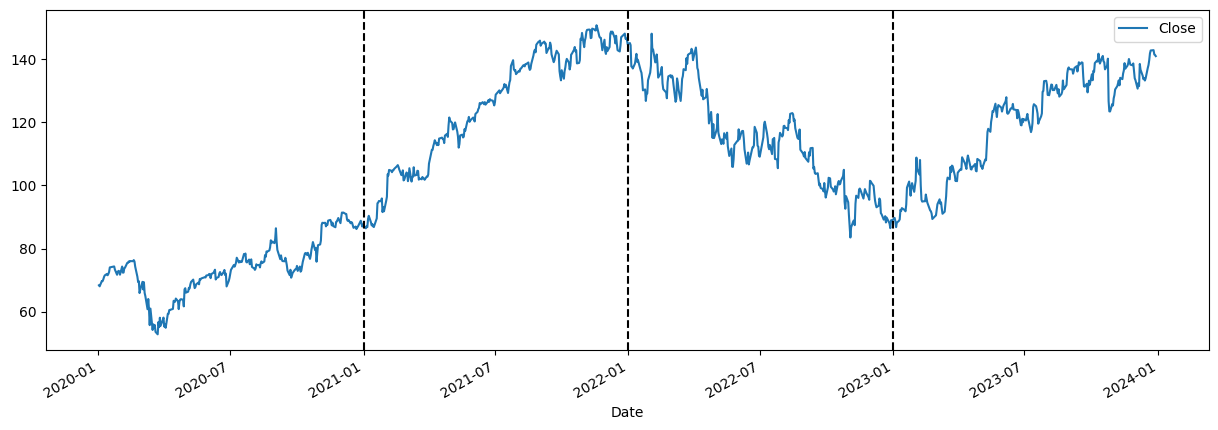

In [99]:
# Plot the data
vlines = ['2021-01-01', '2022-01-01', '2023-01-01']

df.plot(y='Close', figsize=(15,5))

for line in vlines:
  plt.axvline(x=line, color='black', linestyle='--')

plt.show()

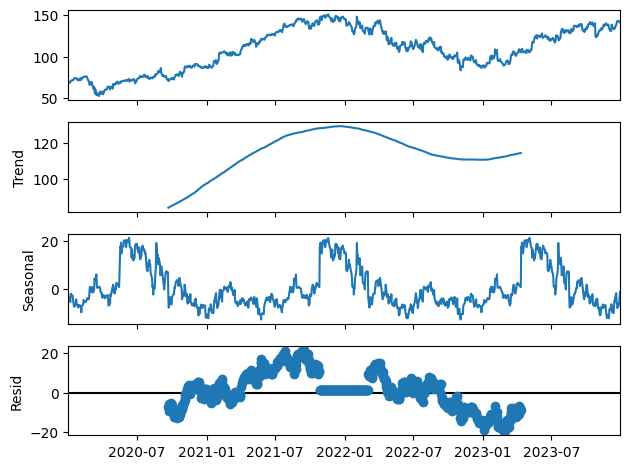

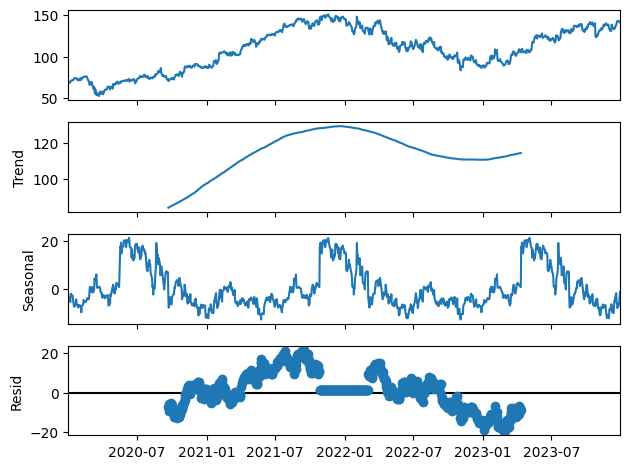

In [100]:
# Plot the decompose item
series = df[['Close']].copy()
decompose_result_mult = seasonal_decompose(series, model="additive", period=365)

decompose_result_mult.plot()

### Create time features

In order to detect the seasonality we can create features based on the date


In [101]:
# Create time features

from pandas.api.types import CategoricalDtype

cat_type_days = CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

cat_type_months = CategoricalDtype(
    categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'],
    ordered=True
)

def create_features(df):

    df = df.copy()

    df['dayofweek'] = df.index.dayofweek
    df['weekday'] = df.index.day_name()
    df['weekday'] = df['weekday'].astype(cat_type_days)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['month'] = df['month'].astype('category')
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['date_offset'] = (df.index.month*100 + df.index.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                            labels=['Spring', 'Summer', 'Fall', 'Winter']
                    )

    return df

df = create_features(df)

df.head()

,Open,High,Low,Close,Adj Close,Volume,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
Date,,,,,,,,,,,,,,,,
2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000,3,Thursday,1,1,2020,2,2,1,1082,Winter
2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000,4,Friday,1,1,2020,3,3,1,1083,Winter
2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000,0,Monday,1,1,2020,6,6,2,1086,Winter
2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000,1,Tuesday,1,1,2020,7,7,2,1087,Winter
2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000,2,Wednesday,1,1,2020,8,8,2,1088,Winter


# Traing The Model


### Split Test & Train Data

In [102]:
X = df[['dayofweek', 'weekday', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'season']]

y = df['Close']

# Split training and validation data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 804 entries, 2021-08-03 to 2022-09-20
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofweek   804 non-null    int64   
 1   weekday     804 non-null    category
 2   quarter     804 non-null    int64   
 3   month       804 non-null    category
 4   year        804 non-null    int64   
 5   dayofyear   804 non-null    int64   
 6   dayofmonth  804 non-null    int64   
 7   weekofyear  804 non-null    UInt32  
 8   season      803 non-null    category
dtypes: UInt32(1), category(3), int64(5)
memory usage: 44.9 KB


In [103]:
# Get numerical and categorical features list

numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'UInt32']]
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['object', 'category']]

my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

### Create Pipeline
Pipeline will contain all transformation steps (Preprocessor), then bundle with the defined model

In [104]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['dayofweek', 'quarter', 'year', 'dayofyear',
                                  'dayofmonth', 'weekofyear']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['weekday', 'month', 'season'])])

In [105]:
# Create the model
model = xgb.XGBRegressor()

In [106]:
# Bundle preprocessor and model to pipeline

my_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['dayofweek', 'quarter',
                                                   'year', 'dayofyear',
                                                   'dayofmonth',
                                                   'weekofyear']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weekday', 'month',
                                                   'season'])])),
                ('model',
                 XGBRe...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

# Evaluate The Model

In [107]:
# Preprocessing validation data, get predictions
preds = abs(my_pipeline.predict(X_valid))

### Evaluation Metrics

* MAE (Mean Absolute Error): The average of the absolute differences between predicted and actual values.
* RMSE (Root Mean Squared Error): The square root of the average of the squared differences between predicted and actual values.
* SMAPE (Symmetric Mean Absolute Percentage Error): The average of the absolute percentage differences between predicted and actual values, scaled by the sum of the absolute values of the predicted and actual values.

In [108]:
# Evaluate the model
#
# Mean Absolute Error
mae = mean_absolute_error(y_valid, preds)

# Root Mean Square Error
mse = mean_squared_error(y_valid, preds)
rmse = np.sqrt(mse)

# Symetric MAPE
actual = np.array(y_valid)
predicted = np.array(preds)
numerator = np.abs(actual - predicted)
denominator = (np.abs(actual) + np.abs(predicted)) / 2
smape = np.mean(numerator / denominator) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"SMAPE: {smape:.2f}%")

MAE: 2.16
RMSE: 2.95
SMAPE: 1.98%


In [109]:
# Save validation in dataframe
valid_df = pd.DataFrame(y_valid)
valid_df['preds'] = preds

valid_df.head()

,Close,preds
Date,,
2022-10-26,94.820000,88.815453
2022-08-24,114.699997,117.569275
2021-03-10,102.751503,103.254654
2021-06-02,121.064003,121.563362
2022-04-07,136.464996,139.115692


[]

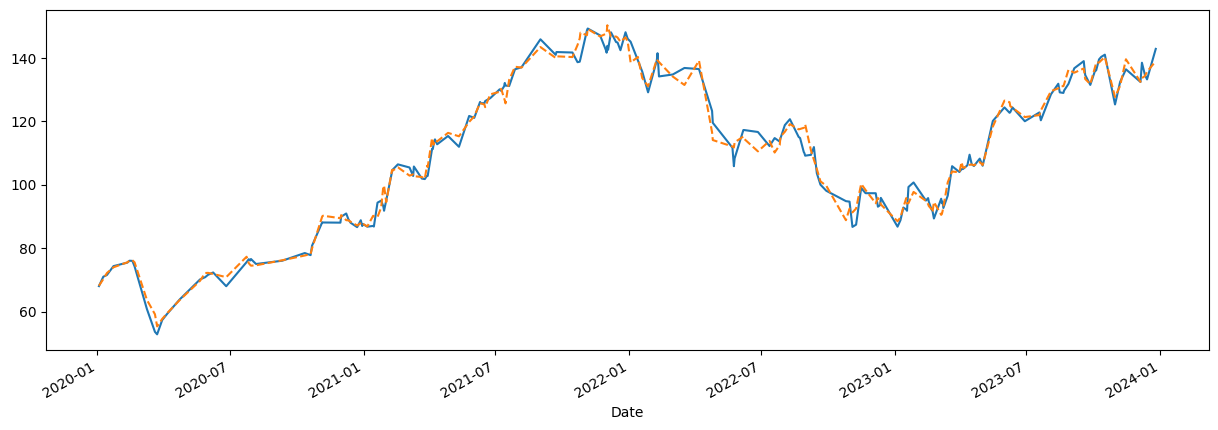

In [110]:
# Plot Actuals vs Forecast

valid_df['Close'].plot(figsize=(15,5))
valid_df['preds'].plot(figsize=(15,5), style='--')
plt.plot()

### Forecast

In [111]:
# Retrain model with full data
my_pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['dayofweek', 'quarter',
                                                   'year', 'dayofyear',
                                                   'dayofmonth',
                                                   'weekofyear']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weekday', 'month',
                                                   'season'])])),
                ('model',
                 XGBRe...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [112]:
# Create a forecast horizon

# Get max date
max_date = df.index.max() + timedelta(days=1)
end_date = max_date + timedelta(days=180)

print('Max Date: ', max_date)
print('End Date: ', end_date)

Max Date:  2023-12-30 00:00:00
End Date:  2024-06-27 00:00:00


In [113]:
# Define the forecast horizon
future = pd.date_range(max_date, end_date, freq='D')

# Add a column to identify future and pass data
df['Forecast'] = False


In [114]:
# Create a data frame to save the forecast
future_df = pd.DataFrame(index=future)
future_df['Forecast'] = True

# Concat both dataframes
df_and_future = pd.concat([df, future_df])

df_and_future.head()

,Open,High,Low,Close,Adj Close,Volume,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season,Forecast
2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000.0,3.0,Thursday,1.0,1,2020.0,2.0,2.0,1,1082.0,Winter,False
2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000.0,4.0,Friday,1.0,1,2020.0,3.0,3.0,1,1083.0,Winter,False
2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000.0,0.0,Monday,1.0,1,2020.0,6.0,6.0,2,1086.0,Winter,False
2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000.0,1.0,Tuesday,1.0,1,2020.0,7.0,7.0,2,1087.0,Winter,False
2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000.0,2.0,Wednesday,1.0,1,2020.0,8.0,8.0,2,1088.0,Winter,False


In [115]:
# Call function to create time features
df_and_future = create_features(df_and_future)

df_and_future.head(-5)

,Open,High,Low,Close,Adj Close,Volume,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season,Forecast
2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000.0,3,Thursday,1,1,2020,2,2,1,1082,Winter,False
2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000.0,4,Friday,1,1,2020,3,3,1,1083,Winter,False
2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000.0,0,Monday,1,1,2020,6,6,2,1086,Winter,False
2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000.0,1,Tuesday,1,1,2020,7,7,2,1087,Winter,False
2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000.0,2,Wednesday,1,1,2020,8,8,2,1088,Winter,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-18,NaN,NaN,NaN,NaN,NaN,NaN,1,Tuesday,2,6,2024,170,18,25,298,Spring,True
2024-06-19,NaN,NaN,NaN,NaN,NaN,NaN,2,Wednesday,2,6,2024,171,19,25,299,Spring,True
2024-06-20,NaN,NaN,NaN,NaN,NaN,NaN,3,Thursday,2,6,2024,172,20,25,300,Spring,True
2024-06-21,NaN,NaN,NaN,NaN,NaN,NaN,4,Friday,2,6,2024,173,21,25,301,Summer,True


In [116]:
# Make predictions
df_and_future['pred'] = my_pipeline.predict(df_and_future[X.columns])

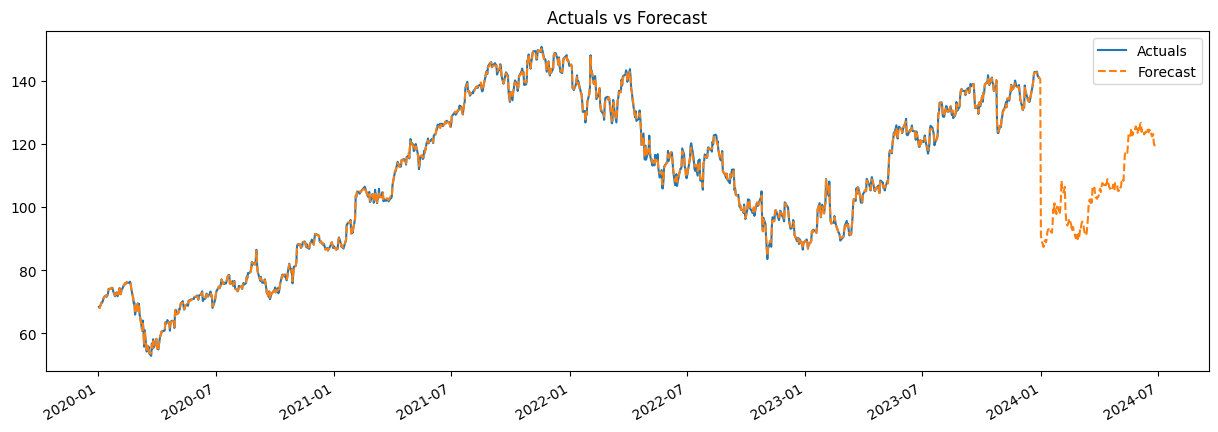

In [117]:
# Plot Training and forecast

df_and_future['Close'].plot(figsize=(15, 5),
                               title='Actuals vs Forecast'
                               ,label='Actuals')

df_and_future['pred'].plot(figsize=(15, 5),
                               style='--'
                               ,label='Forecast')
plt.legend()
plt.show()

# Next Steps

* Improve the forecast by grid-search the optimal parameter on the **XGBRegressor**
* Analyze correlation between features to select only the significant